# XGBoost

Install XGBoost
```
!pip install xgboost
```

In [17]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import plot_tree

In [2]:
def load_data(
    path: str, target_map: dict, criteria_nr: int
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Preprocesses the data for training a machine learning model.

    Args:
        path (str): The path to the CSV file containing the data.
        target_map (dict): A dictionary mapping target values to binary labels.
        criteria_nr (int): The number of criteria used for classification.

    Returns:
        tuple: A tuple containing the preprocessed data and the train-test split.
    """
    # Read the data from the CSV file
    data = pd.read_csv(path, header=None)

    # Apply the target mapping to convert target values to binary labels
    data[criteria_nr] = data[criteria_nr].apply(lambda x: target_map[x])

    # Remove duplicate rows from the data
    data = data.drop_duplicates()

    # Split the data into input features and target variable
    data_input = data.iloc[:, :criteria_nr]
    data_target = data[criteria_nr]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        data_input, data_target, test_size=0.2, random_state=1234
    )

    return (X_train, X_test, y_train, y_test)


# Load the data and preprocess it
path = "data/employee selection.csv"
target_map = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1}
criteria_nr = 4
X_train, X_test, y_train, y_test = load_data(path, target_map, criteria_nr)

In [3]:
# Initialize the XGBoost parameters
params = {
    "max_depth": criteria_nr * 2,  # Maximum depth of a tree
    "eta": 0.1,  # Learning rate
    "nthread": 2,  # Number of parallel threads
    "seed": 0,  # Random seed
    "eval_metric": "rmse",  # Evaluation metric
    "monotone_constraints": "("
    + ",".join(["1"] * criteria_nr)
    + ")",  # Monotonic constraints for each criterion (1 = increasing, -1 = decreasing, 0 = no constraint)
    "n_estimators": 1,  # Number of boosting rounds, or trees
}

In [4]:
# Create the XGBoost model
model = xgb.XGBClassifier(**params)


# Train the model

_ = model.fit(X_train, y_train)

In [5]:
# Predict on the training set
y_pred = model.predict(X_train)
predictions = [round(value) for value in y_pred]

# Calculate accuracy on the training set
accuracy = accuracy_score(y_train, predictions)
print(f"Accuracy train: {accuracy:.2%}")

# Predict on the test set
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy test: {accuracy:.2%}")

Accuracy train: 59.41%
Accuracy test: 51.16%


<Axes: >

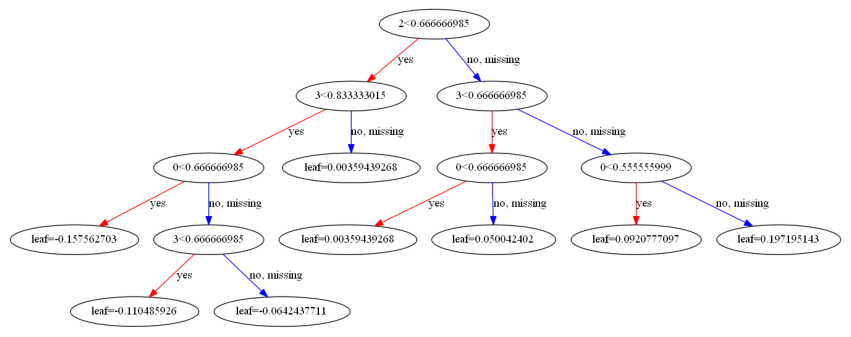

In [6]:
# Plot the first tree in the model
fig, ax = plt.subplots(figsize=(15, 15))

plot_tree(model, ax=ax, num_trees=0)

# Interpretation

In [9]:
booster = model.get_booster()
# F-score represents the frequency of each feature's occurrence in the splits made during the boosting process.
booster.get_fscore()

{'0': 3.0, '2': 1.0, '3': 3.0}

In [10]:
# Weighted verison of F-score
booster.get_score(importance_type="gain")

{'0': 2.274850606918335, '2': 61.5543098449707, '3': 7.707414627075195}

## Partial dependence plot 

In [7]:
def partial_dependency(
    booster: xgb.Booster, X: np.ndarray, y: pd.Series, f_id: int
) -> Tuple[np.ndarray, np.ndarray]:
    """Calculate the partial dependency of a feature on the predicted outcome.


    Args:
        booster (xgb.Booster): The trained XGBoost model.
        X (np.ndarray): The input feature matrix.
        y (pd.Series): The target variable.
        f_id (int): The index of the feature for which the partial dependency is calculated.

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing two numpy arrays:
        - grid: The values of the feature used for calculation.
        - y_pred: The predicted outcomes corresponding to each value in the grid.
    """
    grid = np.linspace(0, 1, 50)
    y_pred = np.zeros(len(grid))
    for i, val in enumerate(grid):
        X_temp = X.copy()
        X_temp[:, f_id] = val
        data = xgb.DMatrix(pd.DataFrame(X_temp))
        y_pred[i] = np.average(booster.predict(data))
    return grid, y_pred

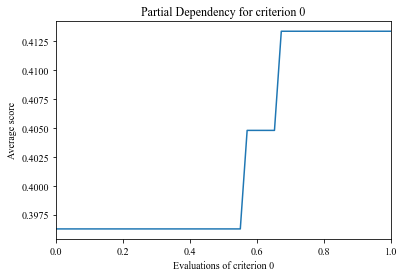

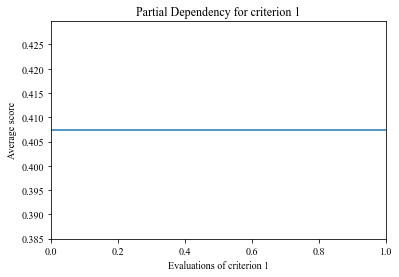

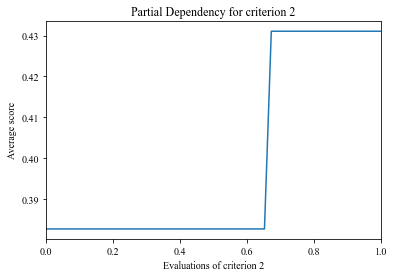

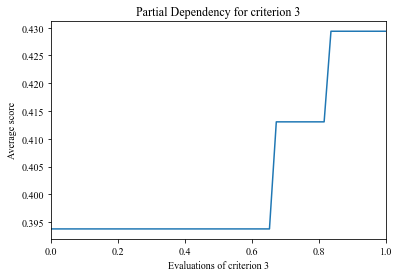

In [8]:

grid = np.linspace(0, 1, 50)

for c in range(criteria_nr):
    grid, y_pred = partial_dependency(booster, X_train.values, y_train, c)
    fig, ax = plt.subplots()
    ax.plot(grid, y_pred)
    ax.set_xlim(0, 1)
    ax.set_title(f"Partial Dependency for criterion {c}")
    ax.set_xlabel(f"Evaluations of criterion {c}")
    ax.set_ylabel("Average score")

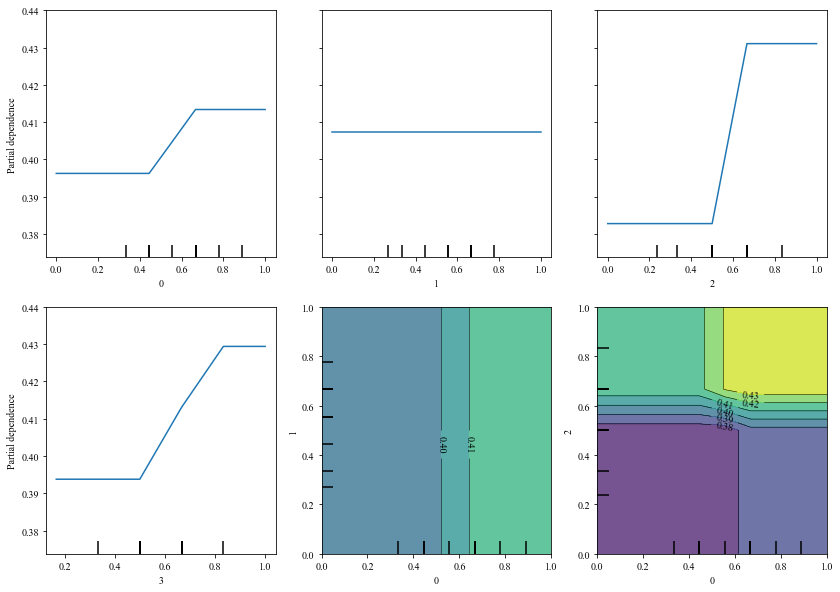

In [11]:

features = [0, 1,2,3, (0, 1),(0,2)]
fig, ax = plt.subplots(figsize=(14, 10))
PartialDependenceDisplay.from_estimator(model, X_train, features, ax=ax)

##  Individual conditional expectation (ICE) plot

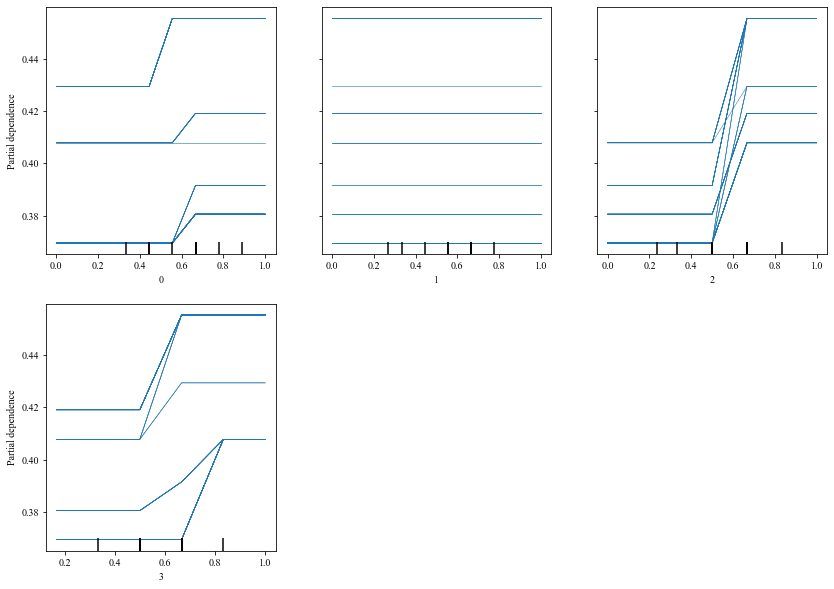

In [12]:

features = [0, 1,2,3]
fig, ax = plt.subplots(figsize=(14, 10))
PartialDependenceDisplay.from_estimator(model, X_train, features, ax=ax,kind='individual')

In [13]:
# Initialize the XGBoost parameters
params = {
    "max_depth": criteria_nr * 2,  # Maximum depth of a tree
    "eta": 0.1,  # Learning rate
    "nthread": 2,  # Number of parallel threads
    "seed": 0,  # Random seed
    "eval_metric": "rmse",  # Evaluation metric
    "monotone_constraints": "("
    + ",".join(["0"] * criteria_nr)
    + ")",  # Monotonic constraints for each criterion (1 = increasing, -1 = decreasing, 0 = no constraint)
    "n_estimators": 3,  # Number of boosting rounds, or trees
}
# Create the XGBoost model
model = xgb.XGBClassifier(**params)
# Train the model
_ = model.fit(X_train, y_train)

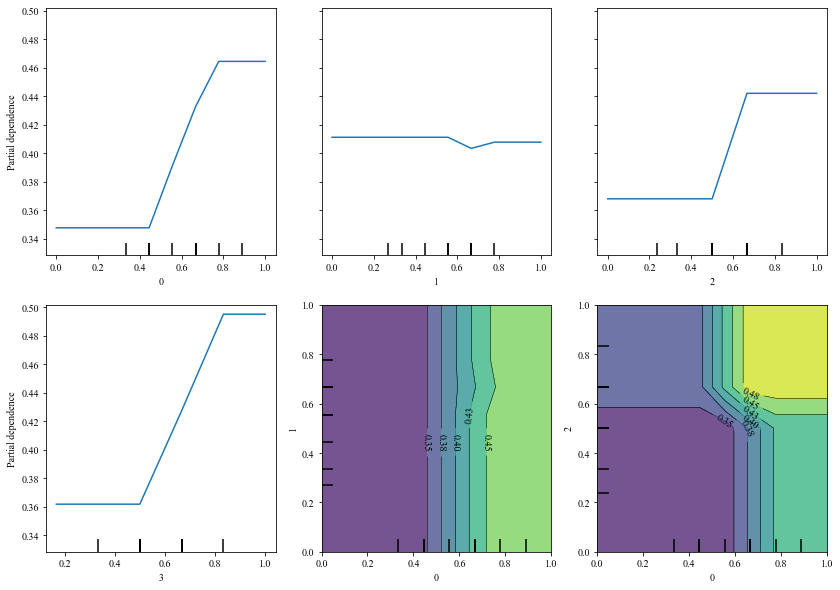

In [14]:
features = [0, 1,2,3, (0, 1),(0,2)]
fig, ax = plt.subplots(figsize=(14, 10))
PartialDependenceDisplay.from_estimator(model, X_train, features, ax=ax)

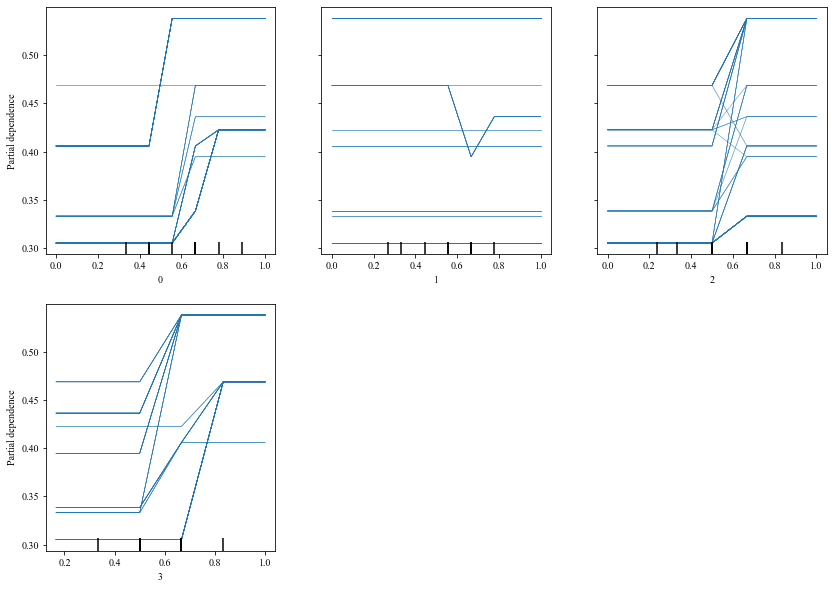

In [15]:

features = [0, 1,2,3]
fig, ax = plt.subplots(figsize=(14, 10))
PartialDependenceDisplay.from_estimator(model, X_train, features, ax=ax,kind='individual')

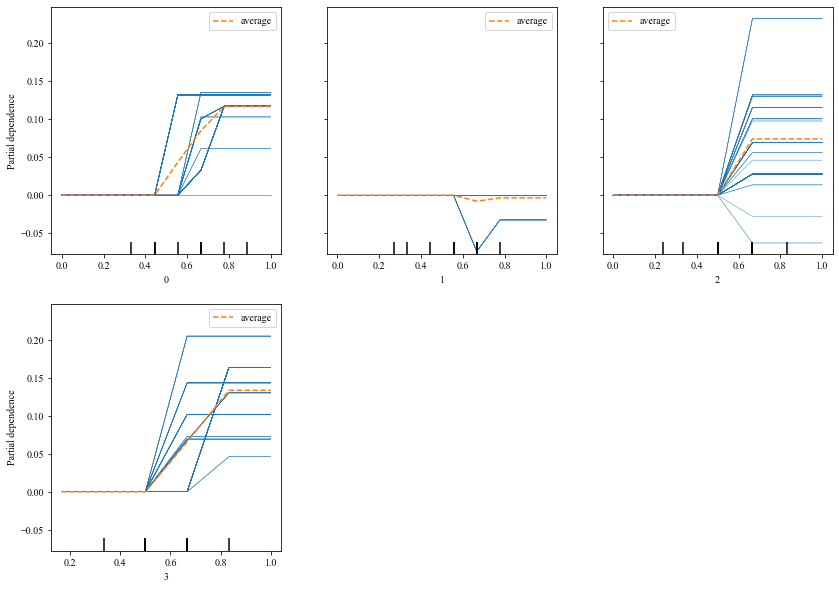

In [16]:
# Centered version that shows the difference from the average prediction, can be useful for finding trends
features = [0, 1,2,3]
fig, ax = plt.subplots(figsize=(14, 10))
PartialDependenceDisplay.from_estimator(model, X_train, features, ax=ax,kind='both', centered=True)

## Permutation feature importance

In [18]:
result = permutation_importance(model, X_train, y_train, n_repeats=10,random_state=0)

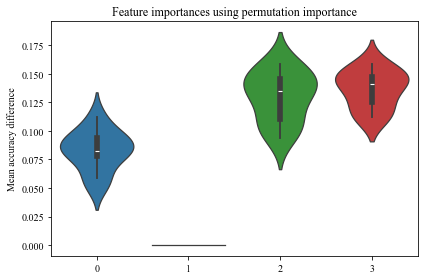

In [39]:
fig, ax = plt.subplots()
sns.violinplot(pd.DataFrame(result.importances.T), ax=ax)
ax.set_title("Feature importances using permutation importance")
ax.set_ylabel("Mean accuracy difference")
fig.tight_layout()